In [42]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import chart_studio.plotly as py
import plotly.express as px
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
fig_dir = join(base_dir, 'figs')
import matplotlib.pyplot as plt
from datetime import datetime as dt
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')


## AcquisitionContrast Column can be dropped

In [25]:
table_dir = join(base_dir, 'data/tables')
dfc = utils.load_scan_csv(join(table_dir, 'neg_pos_clean.csv'))

ipykernel_launcher:2: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
keys = dfc.keys()
TE_k = 'EchoTime'
TR_k = 'RepetitionTime'
TI_k = 'InversionTime'
FA_k = 'FlipAngle'
SD_k = 'SeriesDescription'
PID_k = 'PatientID'
time_k = 'InstanceCreationTime'
date_k = 'InstanceCreationDate'
DT_k = 'DateTime'
SID_k = 'SeriesInstanceUID'
SS_k = 'ScanningSequence'
SV_k = 'SequenceVariant'
SN_k = 'SequenceName'
SO_k = 'ScanOptions'
ETL_k = 'EchoTrainLength'
MFS_k = 'MagneticFieldStrength'

# Acquisition date

## For each volume

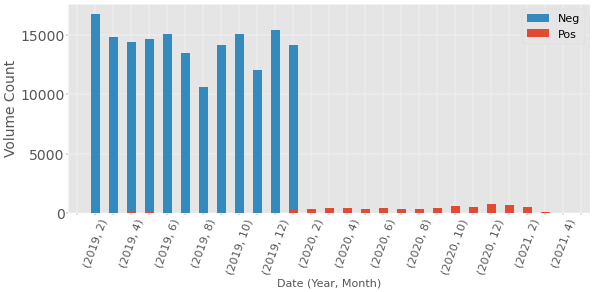

In [40]:
#Now remove all the missing dates
dfc["InstanceCreationDate"] = dfc["InstanceCreationDate"].astype("datetime64")
df_p = dfc[dfc.Positive==1]
df_n = dfc[dfc.Positive==0]

fig, ax = svis.plot_decorator(df_n.groupby([df_n["InstanceCreationDate"].dt.year, \
    df_n["InstanceCreationDate"].dt.month]).Rows.count().plot, 
    figsize=(15,8),
    plot_func_kwargs={'kind':'bar','label':'Neg', 
        'color':svis.Color_palette(0)[1],} ,
    kwargs={'xtickparams_rot':80, 'ylabel':'Volume Count','ylogscale':False,
    })
ax = df_p.groupby([df_p["InstanceCreationDate"].dt.year, \
    df_p["InstanceCreationDate"].dt.month]).Rows.count().plot(kind="bar", 
    color=svis.Color_palette(0)[0], ax=ax, label='Pos')
ax.tick_params(axis='x', which='major', labelsize=20, rotation=70)
ax.set_xlabel('Date (Year, Month)', fontsize=20)
ax.legend(fontsize=20)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

## For each study

In [75]:
def get_studies_df(df, threshold=2):
    """Returns:
        -list with the times between consecutive studies in a dataframe, 
        studies are considered separate if they are at least threshold (default 2) 
        hours apart
        -list with study dates
    """
    df_studies = pd.DataFrame(columns=['PatientID', 'StudyNum',
                    'DateTimeStart', 'NumVolumes'])
    df_sorted = df.groupby('PatientID').apply(
        lambda x: (x.sort_values(by=['DateTime'], ascending=True)))
    patient_ids = df_sorted['PatientID'].unique()
    for patient in patient_ids[:2]:
        print('|', end='')
        study_num = 0
        patient_mask = df_sorted['PatientID'] == patient
        date_times = df_sorted[patient_mask]['DateTime']
        date_time0 = date_times[0]
        df_studies = df_studies.append({'PatientID':patient, 
                                        'StudyNum':study_num,
                                            'DateTimeStart':date_time0}, 
                                        ignore_index=True)
        for date_time in date_times[1:]:
            print('.', end='')
            time_diff = date_time-date_time0
            if time_diff.total_seconds()/3600 > threshold:
                study_num+=1
                df_studies = df_studies.append({'PatientID':patient, 
                                        'StudyNum':study_num,
                                        'DateTimeStart':date_time}, 
                                        ignore_index=True)
                date_time0 = date_time
    return df_studies

In [76]:
df_studies = get_studies_df(dfc)

In [73]:
df_studies

,PatientID,StudyNum,DateTimeStart
0,0004c6f76c29c48fbdf035510d8633e8,0,2019-10-17 11:32:24
